In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys
import meep as mp
import numpy as np

#setup some constants and parameters
M=2**21
tsim=7e-12
eps0 = 8.854187e-12
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12
deltap = np.sqrt(1/3/eps0/hbar/c)*kb
T=30000

#define square root of Dn function
def Dnsqt(wla,T):
    return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)

#generate an array of the square root of Dn function
Dsqt = []
for n in range(1,M):
    Dsqt.append(Dnsqt(2*np.pi*n/tsim,T))

#define how many times to run to average the results
Ncomp=10
nfreq =  1000
#define the starting sum of the result
Efsum = np.zeros(nfreq)
Ens = np.zeros(2*22)
resolution = 100
sz = 16  
cell = mp.Vector3(0, 0, sz)
dpml = 1.0
pml_layers = [mp.PML(dpml)]



for i in range(Ncomp):
    
    #generate random numbers
    M0 = np.random.normal(0,1)
    Mlp = np.random.normal(0,1,M-1)
    Nlp = np.random.normal(0,1,M-1)
    MM = np.random.normal(0,1)
    
    #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
    #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
    #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
    Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
    Eflp = np.multiply((Mlp + 1j*Nlp), Dsqt)
    Eflm = np.flip(np.conjugate(Eflp))
    EfM = np.array([MM*Dnsqt(2*np.pi*M/tsim,T)])
    Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
    #we normalize Ef and compute its inverse fast fourier transform
    Efn = deltap*T/np.sqrt(tsim)*Ef
    En = np.fft.ifft(Efn)
    
    
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('😁'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)
    def source(t):
        f = int(t*100)
        return En[f]

    sources = [mp.Source(mp.CustomSource(src_func=source),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,-0.5*sz+dpml),
                     #amplitude=2e-9
                     )]
    
    sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    dimensions = 1,
                    Courant = 1,
                    resolution=resolution)
    
     # number of frequencies at which to compute flux
    fcen = 0.2  # pulse center frequency
    df = 0.4     # pulse width (in frequency)

    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(0,0,-0.5*sz+dpml+0.5))#, size=mp.Vector3(0,2,0))
    tran = sim.add_flux(fcen, df, nfreq, tran_fr)
    
    
    sim.run(until=2100)

    tran_flux = mp.get_fluxes(tran)
    flux_freqs = mp.get_flux_freqs(tran)
    Ts = []
    fs = []
    for i in range(nfreq):
        fs = np.append(fs,flux_freqs[i])
        Ts = np.append(Ts,tran_flux[i])    
    Efsum += Ts
    
    
    

#average the final result
Efavg = Efsum/Ncomp

#save data to some file or reload file to write more data on it



[                    ] 0%-----------
Initializing structure...
time for choose_chunkdivision = 0.000500917 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 16 with resolution 100
time for set_epsilon = 0.00183201 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2100.0)

Meep progress: 325.14/2100.0 = 15.5% done in 4.0s, 21.8s to go
on time step 32943 (time=329.43), 0.000121424 s/step
Meep progress: 688.26/2100.0 = 32.8% done in 8.0s, 16.4s to go
on time step 69287 (time=692.87), 0.000110061 s/step
Meep progress: 1088.02/2100.0 = 51.8% done in 12.0s, 11.2s to go
on time step 109352 (time=1093.52), 9.98396e-05 s/step
Meep progress: 1508.1100000000001/2100.0 = 71.8% done in 16.0s, 6.3s to go
on time step 151365 (time=1513.65), 9.52097e-05 s/step
Meep progress: 1927.15/2100.0 = 91.8% done in 20.0s, 1.8s to go
on time step 193273 (time=1932.73), 9.54488e-05 s/step
run 0 finished at t = 2100.0 (210000 timesteps)
[😁😁😁😁😁😁😁😁😁😁          ] 10%-----------
Initializing structure...
time for choose_chunkdivision = 0.000113964 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 16 with resolution 100
time for set_epsilon = 0.00169492 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2100.0)

Meep progress: 392.14/2100.0 = 18.7% done in 4.0s, 17.4s to go
on time step 39249 (time=392.49), 0.000101915 s/step
Meep progress: 786.0/2100.0 = 37.4% done in 8.0s, 13.4s to go
on time step 78653 (time=786.53), 0.000101513 s/step
Meep progress: 1207.04/2100.0 = 57.5% done in 12.0s, 8.9s to go
on time step 120781 (time=1207.81), 9.49499e-05 s/step
Meep progress: 1631.46/2100.0 = 77.7% done in 16.0s, 4.6s to go
on time step 163239 (time=1632.39), 9.42128e-05 s/step
Meep progress: 2055.89/2100.0 = 97.9% done in 20.0s, 0.4s to go
on time step 205694 (time=2056.94), 9.42179e-05 s/step
run 0 finished at t = 2100.0 (210000 timesteps)
[😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁] 20%-----------
Initializing structure...
time for choose_chunkdivision = 0.000128984 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 16 with resolution 100
time for set_epsilon = 0.00171709 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2100.0)

Meep progress: 423.78000000000003/2100.0 = 20.2% done in 4.0s, 15.8s to go
on time step 42404 (time=424.04), 9.43315e-05 s/step
Meep progress: 841.01/2100.0 = 40.0% done in 8.0s, 12.0s to go
on time step 84147 (time=841.47), 9.58268e-05 s/step
Meep progress: 1249.43/2100.0 = 59.5% done in 12.0s, 8.2s to go
on time step 125014 (time=1250.14), 9.78803e-05 s/step
Meep progress: 1664.47/2100.0 = 79.3% done in 16.0s, 4.2s to go
on time step 166527 (time=1665.27), 9.63559e-05 s/step
Meep progress: 2085.84/2100.0 = 99.3% done in 20.0s, 0.1s to go
on time step 208681 (time=2086.81), 9.48904e-05 s/step
run 0 finished at t = 2100.0 (210000 timesteps)
[😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁] 30%-----------
Initializing structure...
time for choose_chunkdivision = 0.000114918 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 16 with resolution 100
time for set_epsilon = 0.001827 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2100.0)

Meep progress: 420.07/2100.0 = 20.0% done in 4.0s, 16.0s to go
on time step 42043 (time=420.43), 9.51413e-05 s/step
Meep progress: 831.69/2100.0 = 39.6% done in 8.0s, 12.2s to go
on time step 83217 (time=832.17), 9.71578e-05 s/step
Meep progress: 1222.3/2100.0 = 58.2% done in 12.0s, 8.6s to go
on time step 122300 (time=1223), 0.000102348 s/step
Meep progress: 1644.4/2100.0 = 78.3% done in 16.0s, 4.4s to go
on time step 164532 (time=1645.32), 9.47151e-05 s/step
Meep progress: 2044.3600000000001/2100.0 = 97.4% done in 20.0s, 0.5s to go
on time step 204527 (time=2045.27), 0.000100014 s/step
run 0 finished at t = 2100.0 (210000 timesteps)
[😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁] 40%-----------
Initializing structure...
time for choose_chunkdivision = 0.000138998 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 16 with resolution 100
time for set_epsilon = 0.00183916 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2100.0)

Meep progress: 366.46/2100.0 = 17.5% done in 4.0s, 18.9s to go
on time step 36673 (time=366.73), 0.000109075 s/step
Meep progress: 689.15/2100.0 = 32.8% done in 8.0s, 16.4s to go
on time step 68948 (time=689.48), 0.000123938 s/step
Meep progress: 1054.53/2100.0 = 50.2% done in 12.0s, 11.9s to go
on time step 105501 (time=1055.01), 0.000109433 s/step
Meep progress: 1410.9/2100.0 = 67.2% done in 16.0s, 7.8s to go
on time step 141135 (time=1411.35), 0.000112256 s/step
Meep progress: 1776.41/2100.0 = 84.6% done in 20.0s, 3.6s to go
on time step 177704 (time=1777.04), 0.000109383 s/step
Meep progress: 2092.17/2100.0 = 99.6% done in 24.0s, 0.1s to go
on time step 209272 (time=2092.72), 0.000126714 s/step
run 0 finished at t = 2100.0 (210000 timesteps)
[😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁] 50%-----------
Initializing structure...
time for choose_chunkdivision = 0.000137091 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 16 with resolution 100
time for set_epsilon = 0.

FloatProgress(value=0.0, description='0% done ', max=2100.0)

Meep progress: 388.44/2100.0 = 18.5% done in 4.0s, 17.6s to go
on time step 38867 (time=388.67), 0.000102917 s/step
Meep progress: 793.11/2100.0 = 37.8% done in 8.0s, 13.2s to go
on time step 79333 (time=793.33), 9.88484e-05 s/step
Meep progress: 1172.56/2100.0 = 55.8% done in 12.0s, 9.5s to go
on time step 117298 (time=1172.98), 0.000105362 s/step
Meep progress: 1566.0/2100.0 = 74.6% done in 16.0s, 5.5s to go
on time step 156649 (time=1566.49), 0.000101659 s/step
Meep progress: 1948.64/2100.0 = 92.8% done in 20.0s, 1.6s to go
on time step 194913 (time=1949.13), 0.000104537 s/step
run 0 finished at t = 2100.0 (210000 timesteps)
[😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁] 60%-----------
Initializing structure...
time for choose_chunkdivision = 0.000104904 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 16 with resolution 100
time for set_epsilon = 0.00183201 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2100.0)

Meep progress: 381.66/2100.0 = 18.2% done in 4.0s, 18.0s to go
on time step 38196 (time=381.96), 0.000104725 s/step
Meep progress: 796.75/2100.0 = 37.9% done in 8.0s, 13.1s to go
on time step 79718 (time=797.18), 9.63348e-05 s/step
Meep progress: 1211.98/2100.0 = 57.7% done in 12.0s, 8.8s to go
on time step 121252 (time=1212.52), 9.63072e-05 s/step
Meep progress: 1589.21/2100.0 = 75.7% done in 16.0s, 5.1s to go
on time step 158978 (time=1589.78), 0.000106028 s/step
Meep progress: 1968.52/2100.0 = 93.7% done in 20.0s, 1.3s to go
on time step 196912 (time=1969.12), 0.000105448 s/step
run 0 finished at t = 2100.0 (210000 timesteps)
[😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁] 70%-----------
Initializing structure...
time for choose_chunkdivision = 0.000544071 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 16 with resolution 100
time for set_epsilon = 0.00189781 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2100.0)

Meep progress: 355.98/2100.0 = 17.0% done in 4.0s, 19.6s to go
on time step 35621 (time=356.21), 0.000112296 s/step
Meep progress: 691.98/2100.0 = 33.0% done in 8.0s, 16.3s to go
on time step 69227 (time=692.27), 0.000119027 s/step
Meep progress: 1080.31/2100.0 = 51.4% done in 12.0s, 11.3s to go
on time step 108066 (time=1080.66), 0.000102992 s/step
Meep progress: 1438.8600000000001/2100.0 = 68.5% done in 16.0s, 7.4s to go
on time step 143932 (time=1439.32), 0.000111527 s/step
Meep progress: 1788.89/2100.0 = 85.2% done in 20.0s, 3.5s to go
on time step 178937 (time=1789.37), 0.000114272 s/step
run 0 finished at t = 2100.0 (210000 timesteps)
[😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁] 80%-----------
Initializing structure...
time for choose_chunkdivision = 0.000119925 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 16 with resolution 100
time for set_epsilon = 0.00183201 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2100.0)

Meep progress: 389.03000000000003/2100.0 = 18.5% done in 4.0s, 17.6s to go
on time step 38941 (time=389.41), 0.000102722 s/step
Meep progress: 766.61/2100.0 = 36.5% done in 8.0s, 13.9s to go
on time step 76718 (time=767.18), 0.000105887 s/step
Meep progress: 1164.44/2100.0 = 55.4% done in 12.0s, 9.6s to go
on time step 116508 (time=1165.08), 0.000100529 s/step
Meep progress: 1567.98/2100.0 = 74.7% done in 16.0s, 5.4s to go
on time step 156885 (time=1568.85), 9.9067e-05 s/step
Meep progress: 1955.89/2100.0 = 93.1% done in 20.0s, 1.5s to go
on time step 195667 (time=1956.67), 0.000103141 s/step
run 0 finished at t = 2100.0 (210000 timesteps)
[😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁😁] 90%-----------
Initializing structure...
time for choose_chunkdivision = 0.000118017 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 16 with resolution 100
time for set_epsilon = 0.00182199 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2100.0)

Meep progress: 407.87/2100.0 = 19.4% done in 4.0s, 16.6s to go
on time step 40820 (time=408.2), 9.79913e-05 s/step
Meep progress: 811.71/2100.0 = 38.7% done in 8.0s, 12.7s to go
on time step 81227 (time=812.27), 9.89935e-05 s/step
Meep progress: 1197.5/2100.0 = 57.0% done in 12.0s, 9.0s to go
on time step 119827 (time=1198.27), 0.000103629 s/step
Meep progress: 1597.28/2100.0 = 76.1% done in 16.0s, 5.0s to go
on time step 159817 (time=1598.17), 0.000100027 s/step
Meep progress: 2003.8400000000001/2100.0 = 95.4% done in 20.0s, 1.0s to go
on time step 200476 (time=2004.76), 9.83812e-05 s/step
run 0 finished at t = 2100.0 (210000 timesteps)


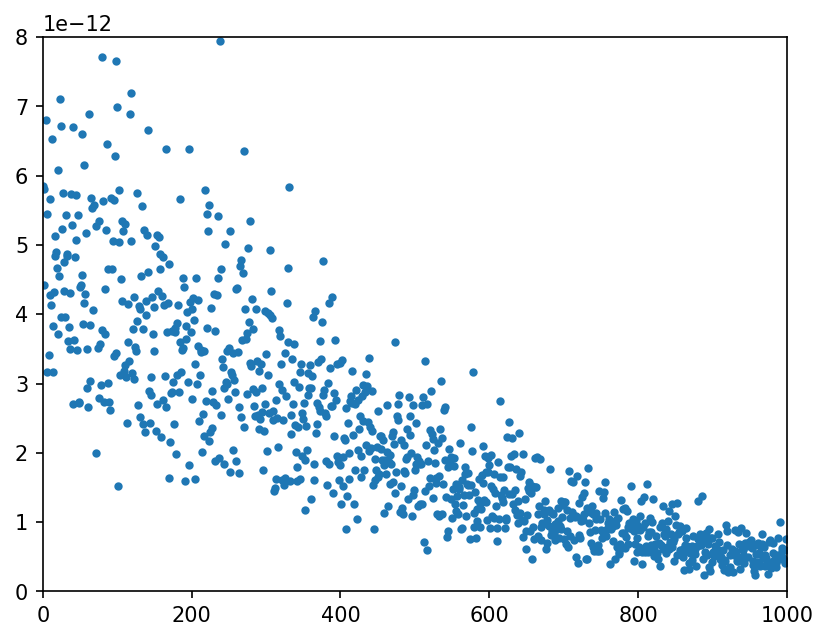

In [2]:
plt.figure(dpi=150)
#freqs = np.linspace(0,2*np.pi*2**22/(7*1e-12),1000)
plt.plot(Efavg,'.')
plt.xlim(0,1000)
plt.ylim(0,8*1e-12)
plt.savefig('detector_vacuum_300001.png')
plt.show()

#np.savez("custom_source_vacuum_30000.npz", Efavg_30000 = Efavg)

In [31]:
from PIL import Image

def transPNG(srcImageName, dstImageName):
    img = Image.open(srcImageName)
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = list()
    for item in datas:
        if item[0] > 225 and item[1] > 225 and item[2] > 225:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    img.save(dstImageName, "PNG")
transPNG('detector_vacuum_300001.png','trans_detector_vacuum_300001.png')